<font size=6><b>[실습] Efficient Frontier

* Efficient Frontier(효율적 투자선) 
    * 서로 다른 위험-수익률로 구성된 종목들 중 지배원리에 따라 가장 우수한 종목들을 연결한 선
* 지배원리
    * 같은 위험 하에서 기대수익률이 높은 종목이 기대수익률이 낮은 종목을 지배한다는 원리
    * 기대수익률이 같을 경우는 낮은 위험이 우수
* <font color=red>포트폴리오 비중을 어떻게 구성하느냐에 따라 더 높은 수익률과 더 낮은 위험을 기대할 수 있다

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy, scipy.stats
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()


import warnings
warnings.filterwarnings(action='ignore')

# Data load

In [2]:
sdate = "2012-01-01"
edate = "2021-12-31"
df1 = yf.download('AAPL',sdate, edate)['Close']
df2 = yf.download('GLD', sdate, edate)['Close']
df3 = yf.download('^DJI',sdate, edate)['Close']
df  = pd.concat([df1, df2, df3 ], axis=1)
df.columns = ["aapl","gld","nasdaq"]
df = df.dropna()
ret = df.pct_change().dropna()
ret.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,aapl,gld,nasdaq
Date,,,
2012-01-04,0.005374,0.005067,0.001697
2012-01-05,0.011102,0.006828,-0.000219
2012-01-06,0.010454,-0.003676,-0.004493
2012-01-09,-0.001586,-0.004453,0.002651
2012-01-10,0.003580,0.013674,0.005631


# 가격추이

In [3]:
df.head()

,aapl,gld,nasdaq
Date,,,
2012-01-03,14.686786,155.919998,12397.379883
2012-01-04,14.765714,156.710007,12418.419922
2012-01-05,14.929643,157.779999,12415.700195
2012-01-06,15.085714,157.199997,12359.919922
2012-01-09,15.061786,156.500000,12392.690430


# 가격추이

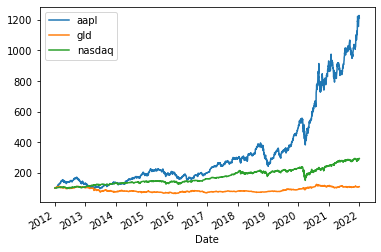

In [4]:
(df / df.iloc[0]*100).plot()
plt.show()

# 최소분산포트폴리오(Minimum Volatility Portfolio, MVP)

## 비중

In [5]:
w = np.random.random(len(df.columns)) 
w = w / np.sum(w) 
print(w)

[0.03400342 0.37431729 0.59167928]


## 연간수익률

In [6]:
pmean = np.sum(w*ret.mean())*250
print(f"수익률:{pmean}")

수익률:0.08876902412325394


## 위험

In [7]:
pvar = np.dot(w.T,np.dot(ret.cov()*250, w))
pstd = np.sqrt(pvar)
print(f"분산:{pvar} , 편차:{pstd}")

분산:0.014070676119772613 , 편차:0.11861988079480021


## 임의 포트폴리오 수익률 

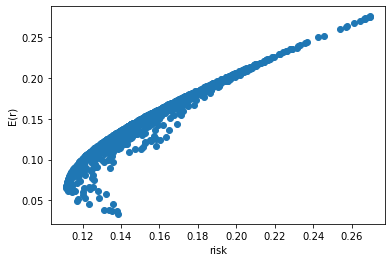

In [8]:
noa = len(df.columns)
ret_list     = []
risk_list    = []
sharp_list   = []
weight_list  = []
for w in range(1000):
    w = np.random.random(len(df.columns)) 
    w /= np.sum(w)
    
    mean = np.sum(w*ret.mean())*250
    std  = np.sqrt(np.dot(w.T,np.dot(ret.cov()*250, w)) )
    ret_list.append(mean)
    risk_list.append(std)
    sharp_list.append(mean / std) 
    weight_list.append(w)
plt.scatter(risk_list, ret_list)

plt.xlabel("risk")
plt.ylabel("E(r)")
plt.show()

## 포트폴리오 평가 : 샤프지수(Sharpe Ratio)
* 리스크(std) vs 수익률(mean) 관계
* 포트폴리오 내에서 인내할 있는 리스크 대비 최대 수익률
* 샤프 =  (수익률-무위험수익률)/표준편차(리스크)

In [9]:
 #

## 최적화 해 찾기
* SLSQP(Sequential Least SQuares Programming)
    * 복잡한 현실 문제를 단순화해 목적함수를 이차식으로 근사해 풀고 다음 번 지점을 예측해 다시 동일한 방법을 수행하는 문제를 푸는 알고리즘
    * 비선형 최적화 해 찾기에 일반적으로 사용 
    * 제약조건(constraint)과 상하한선(bound) 필요

In [10]:
# scipy.optimize.minimize(
#     fun,               #목적함수
#     x0,                #초깃값
#     args=( ),          #목적함수 파라미터
#     method=None,       #최적화메서드, 일반적으로  SLSQP  사용
#     bounds=None,       #경계값
#     constraints=( ),   #제약조건
#     jac=None, hess=None, hessp=None,
#     tol=None, callback=None, options=None )

* 연습

In [11]:
from scipy.optimize import minimize

def my_objfunc( x ):   
    return x + 1        #목적함수 : y=x+1

x0  = [ 1 ]             #초기값 : 1

b   = ( 2, 5 )          #해의범위 : 2,3,4,5
bnd = ( b, )


def my_constraint( x ):
    return x-3         #제약조건 : x>=3
con = { 'type':'ineq', 'fun':my_constraint }

sol = minimize( my_objfunc, x0, method='SLSQP', bounds=bnd, constraints=con ) #최적화
print( sol.x )         #해의범위 중 목적함수y를 최적화(minimize)하는 x

[3.]


## SLSQP 사용

In [22]:
from scipy.optimize import minimize
def my_objfunc(w):
    #return np.sqrt( weights.T @ corr @ weights )         #목적함수
    return np.sqrt(np.dot(w.T,np.dot(ret_list.cov()*250, w)) )

w = weight_list                                          #초깃값: 투자비중
bnds = ( (0,1), (0,1), (0,1) )                           #투자비중한도: 0~100%
cons = ({ 'type': 'eq', 'fun': lambda x: np.sum(x)-1 })  #제약조건: 투자 비중 100%(무차입투자)

res = minimize( my_objfunc, w, method='SLSQP', bounds=bnds, constraints=cons )
print( res )                                             #최적화된 투자비중
 

ValueError: operands could not be broadcast together with shapes (3000,) (3,) (3,) 

## max min 

In [21]:
port_dict = {"ret":ret_list,"risk":risk_list,"sharp":sharp_list,"weight":weight_list}
port_df = pd.DataFrame(port_dict)
print(port_df.shape)
port_df.tail()

(1000, 4)


,ret,risk,sharp,weight
995,0.106074,0.122308,0.867274,"[0.17475867068046205, 0.43597993418690884, 0.3..."
996,0.114766,0.127397,0.900853,"[0.23760882458251611, 0.45398005402140623, 0.3..."
997,0.157998,0.157588,1.002602,"[0.35606194168078664, 0.22257422088235257, 0.4..."
998,0.079822,0.113500,0.703280,"[0.03646752560079183, 0.4668031380813685, 0.49..."
999,0.159602,0.161822,0.986276,"[0.3220058228893971, 0.15043598307041903, 0.52..."


In [14]:
sharp_max = port_df[port_df['sharp'] == port_df['sharp'].max()]
sharp_max

,ret,risk,sharp,weight
166,0.216749,0.209475,1.034722,"[0.6547924802849038, 0.135824400234463, 0.2093..."


In [15]:
risk_min = port_df[port_df['risk'] == port_df['risk'].min()]
risk_min

,ret,risk,sharp,weight
766,0.064759,0.111305,0.581815,"[0.0009711216512321987, 0.5569778154152685, 0...."


In [16]:
ret_max = port_df[port_df['ret'] == port_df['ret'].max()]
ret_max

,ret,risk,sharp,weight
146,0.27613,0.269671,1.023951,"[0.9321179962160085, 0.007455806765420285, 0.0..."


In [ ]:
https://thebook.io/080227/ch04/03/04-01/

https://ktcf.tistory.com/m/58